## Read data

In [177]:
import json

with open("28-09_07-11_alldata.json", "r") as f:
    data = json.load(f)

In [199]:
import pandas as pd
pd.DataFrame(data)

dfs = []
for result in data["results"]:
    serie = result["series"][0]
    for serie in result["series"]:
        df = pd.DataFrame(serie["values"], columns=serie["columns"])
        df.name = serie["name"]
        dfs.append(df)

## Data type
- s_* -> microphone input
- sonic (rmslog) -> low-frequency vibration
- temp
- vib -> vibration
  - acc
  - peak
  - root: removed due to this weird shape  
    ![](https://i.imgur.com/7nI0eCG.png)
  - f1/f2/f3
  - kurt
  - vibra_custom: it's always 1, dropping
  
- ![image.png](https://i.imgur.com/E3wAX58.png)

In [228]:
df = dfs[0]
df_temp = dfs[2]
df_curr = dfs[3]
df = df.drop([
    'client', "GW", "device", "mileage", "vibra_custom",
    'vib_x_root', 'vib_y_root', 'vib_z_root',
], axis=1)
df_temp = df_temp.drop(['client', "GW", "device", 'weekday'], axis=1)
df_curr = df_curr.drop(['client', "GW", "device", 'weekday'], axis=1)

## Join dataframes

- df[0] -> Signature_Drift
- df[1] -> Signature
- df[2] -> Temperature
- df[3] -> Current_Loop

In [229]:

df = df.set_index('time')
df = df.rename(columns={'temp': 'temperature_surface'})
df_temp = df_temp.set_index('time').rename(columns={"value": "temperature_external"})
df_curr = df_curr.set_index('time').rename(columns={"value": "current"})

df = df.join(df_temp)
df = df.join(df_curr)

df = df.reset_index()
df["time"] = pd.to_datetime(df["time"], unit='ms')

# Label and plot

In [230]:
df.loc[(df["time"] >= "2021-10-09") & (df["time"] <= "2021-10-12"), "label"] = "working-engine-1"
df.loc[(df["time"] >= "2021-10-27 17:30") & (df["time"] <= "2021-10-29 00:00"), "label"] = "bearings-1"

df.loc[(df["time"] >= "2021-11-03 16:00") & (df["time"] <= "2021-11-05 11:00"), "label"] = "working-engine-2" # Every 2 minutes (TOCHECK)
df.loc[(df["time"] >= "2021-11-05 13:30") & (df["time"] <= "2021-11-05 23:59"), "label"] = "bearings-2" # Every 2 minutes (TOCHECK)

In [231]:
# Drops nan labels by default
df = df.groupby([df.time.dt.date, df.time.dt.hour, 'label']).mean()
df.index.names = ["date", "hour", 'label']

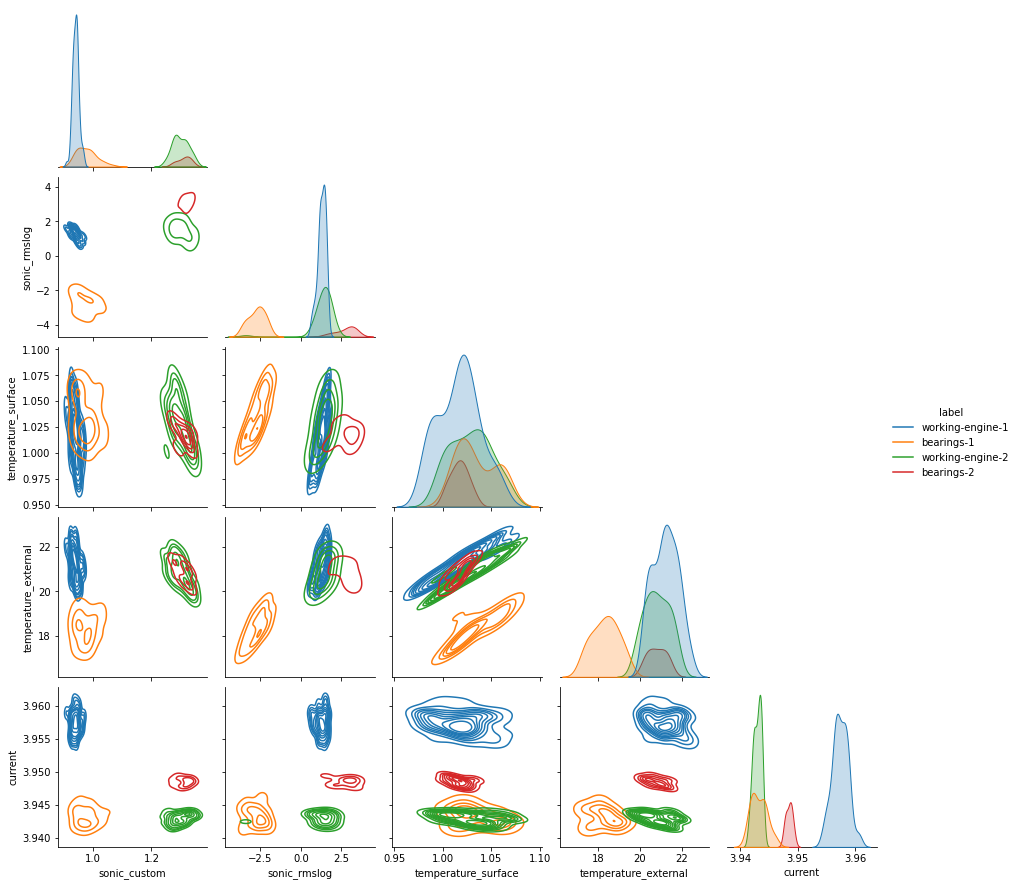

In [232]:
import seaborn as sns
sns.pairplot(
    df.reset_index()[[
        # 's_00', 's_01', 's_02', 's_03', 's_04', 's_05', 's_06', 's_07', 's_08', 's_09', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
        'sonic_custom', 'sonic_rmslog',
        # 'vib_x_acc', 'vib_x_kurt', 'vib_x_peak', 'vib_x_vel',
        # 'vib_y_acc', 'vib_y_kurt', 'vib_y_peak', 'vib_y_vel',
        # 'vib_z_acc', 'vib_z_kurt', 'vib_z_peak', 'vib_z_vel',
        'temperature_surface', 'temperature_external', 'current',
        'label'
    ]],
    kind="kde",
    hue="label",
    corner=True
)

## Dimentinality reduction

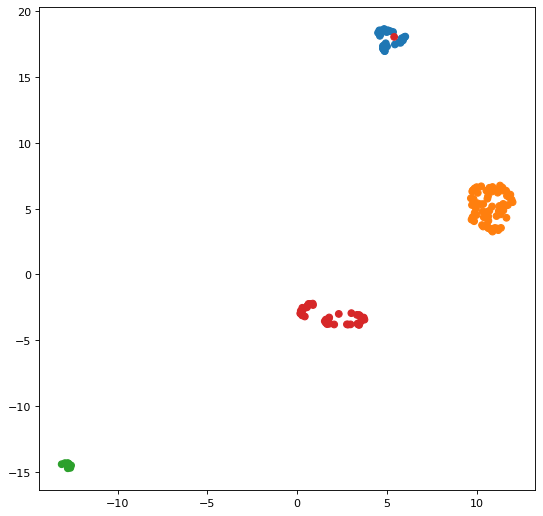

In [217]:
import umap
reducer = umap.UMAP()
embedding= reducer.fit_transform(df)

from matplotlib import pyplot as plt
c=[sns.color_palette()[x] for x in dfa.label.map({"cuscinetti":0, "base":1, "cuscinetti2":2, "base2":3})]
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1],c=c)

/home/marco/projects/SmartElevator/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/marco/projects/SmartElevator/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


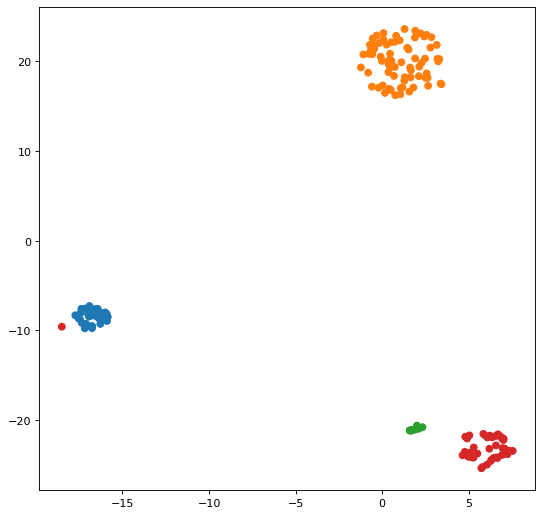

In [218]:
from sklearn.manifold import TSNE
reducer = TSNE()
embedding= reducer.fit_transform(dfa.drop("label", axis=1))
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1],c=c)

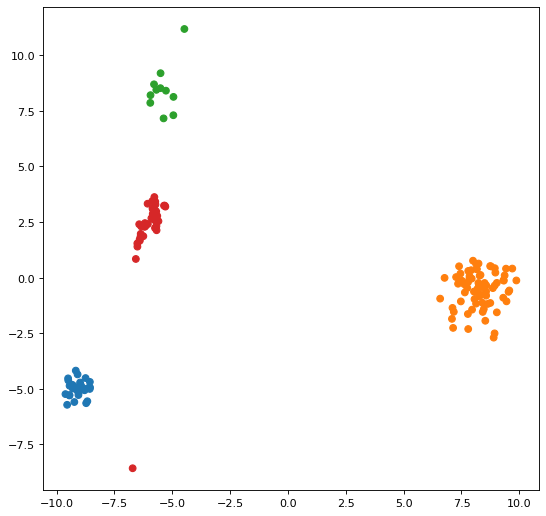

In [219]:
from sklearn.decomposition import PCA
reducer = PCA()
embedding= reducer.fit_transform(dfa.drop("label", axis=1))
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1],c=c)

## Root mean square error

Requires a prediction to have an error

In [ ]:
# # df_loc = df.loc[df["time"] == "2021-10-27 17:32:32.494"]
# df_loc = df.loc[df["time"] >= "2021-10-31 12:05:52.937"]
# print(df_loc.mean())
# df_loc

## Mesurements (For models)
- RMS : root mean square
- variance
- skewness : normalised third central moment
- kurtosis : normalised fourth central moment
- normalised sixth central moment
- PV : peak value